In [71]:
'''Implementing the Iterated Ensemble Kalman Filter. The algorithm is described in https://arxiv.org/abs/2110.10745.
This uses the stochastic update step. '''

'Implementing the Iterated Ensemble Kalman Filter. The algorithm is described in https://arxiv.org/abs/2110.10745.\nThis uses the stochastic update step. '

In [72]:
import numpy as np 
import matplotlib.pyplot as plt

'''Tau leaping model so we have some stochasticity. '''

days = 100
delta_t = 0.1 
rng = np.random.default_rng(0)

def model(theta,rng,*,days,delta_t): 
    beta,gamma = theta

    S = np.zeros(days * int(1/delta_t))
    I = np.zeros(days * int(1/delta_t))
    R = np.zeros(days * int(1/delta_t))

    #Initial condition
    S[0] = 500
    I[0] = 5
    R[0] = 0

    N = S[0] + I[0] + R[0]

    for t in range(1,int(1/delta_t) * days): 

        #Rate equations
        dN_SI = rng.poisson(beta * (S[t-1] * I[t-1]/N) * delta_t)
        dN_IR = rng.poisson(I[t-1] * gamma * delta_t)

        S[t] = S[t-1] - dN_SI
        I[t] = I[t-1] + dN_SI - dN_IR
        R[t] = R[t-1] + dN_IR

    return (S,I,R) 

theta = (0.3,0.1) #Real parameters
_,data_full,_ = model(theta,rng,days = days,delta_t = delta_t)

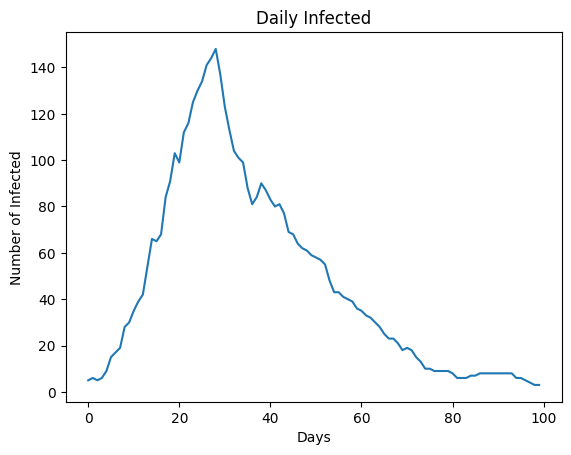

In [73]:
#Extract the data daily
data_real = data_full[::int(1/delta_t)]

plt.title('Daily Infected')
plt.xlabel('Days')
plt.ylabel('Number of Infected')
plt.plot(np.arange(0,days,1),data_real)

In [74]:
def single_step(theta,state,rng,*,delta_t,log = False): 
    beta,gamma = theta
    if log: 
        beta = np.exp(beta)
        gamma = np.exp(gamma)

    S0,I0,R0 = state

    S = np.zeros(int(1/delta_t))
    I = np.zeros(int(1/delta_t))
    R = np.zeros(int(1/delta_t))

    S[0] = S0
    I[0] = I0
    R[0] = R0

    N = S0 + I0 + R0

    for t in range(1,int(1/delta_t)): 

        #Rate equations
        dN_SI = rng.poisson(max(beta * (S[t-1] * I[t-1]/N) * delta_t,0.))
        dN_SI = min(dN_SI,S[t-1])

        dN_IR = rng.poisson(max(I[t-1] * gamma * delta_t,0.))
        dN_IR = min(dN_IR,I[t-1])

        S[t] = S[t-1] - dN_SI
        I[t] = I[t-1] + dN_SI - dN_IR
        R[t] = R[t-1] + dN_IR

    return np.array([S[-1],I[-1],R[-1]]).squeeze()

In [75]:
outer_loop_iterations = 100
num_ensemble_members = 20
scale = 0.02 
Vn = scale**2 * np.eye(2) #Covariance matrix of the parameter perturbations
cooling_schedule = np.flip(np.linspace(0.01,1.0,outer_loop_iterations))

#Unique to EnKF
measurement_noise = 5.
H = np.array([[0.,1.,0.,0.,0.]])

#Initial step 
params = rng.multivariate_normal([-np.log(2),-np.log(2)],np.eye(2),size = (num_ensemble_members))

for iter in range(outer_loop_iterations): 
    print(f"Iteration {iter} with Mean: {np.exp(np.mean(params,axis = 0))}")

    # Draw random normal variates
    cov_sqrt = np.linalg.cholesky(cooling_schedule[iter] * Vn)
    std_vars = rng.normal(size = (num_ensemble_members,2))
    
    #member info
    params = params + std_vars @ cov_sqrt.T
    members = np.full((num_ensemble_members,3),np.array([500,5,0])) #Initialize the particles with the correct I.C.

    for time_index in range(1,len(data_real)): 

        #Draw random normal variates
        std_vars = rng.normal(size = (num_ensemble_members,2))
        params = params + std_vars @ cov_sqrt.T

        #Propagate particles
        for index in range(num_ensemble_members): 
            members[index,...] = single_step(params[index,...],members[index,...],rng,delta_t = 0.1,log = True)

        #Stack all the parameters on the bottom 
        ensemble = np.concatenate((members,params),axis = 1)

        #Prior sample mean and sample covariance
        prior_mean = np.mean(ensemble,axis = 0)
        prior_cov = np.cov(ensemble.T)

        #Kalman gain 
        K = prior_cov @ H.T @ np.linalg.pinv(H @ prior_cov @ H.T + measurement_noise)

        #Update 
        for index in range(num_ensemble_members): 
            eps = rng.normal(0,np.sqrt(measurement_noise))
            ensemble[index] += K @ (data_real[time_index] - H @ ensemble[index] + eps)

            members[index] = np.round(ensemble[index][0:3])
            params[index] = ensemble[index][3:]

        



Iteration 0 with Mean: [0.30945621 0.5081289 ]
Iteration 1 with Mean: [0.33998364 0.12719097]
Iteration 2 with Mean: [0.41405646 0.09438051]
Iteration 3 with Mean: [0.27665843 0.11492131]
Iteration 4 with Mean: [0.2289876  0.09334293]
Iteration 5 with Mean: [0.22864459 0.11013952]
Iteration 6 with Mean: [0.32173872 0.10764443]
Iteration 7 with Mean: [0.34128196 0.09951672]
Iteration 8 with Mean: [0.38378722 0.081078  ]
Iteration 9 with Mean: [0.33904902 0.09291735]
Iteration 10 with Mean: [0.38179249 0.10205752]
Iteration 11 with Mean: [0.27408543 0.10745888]
Iteration 12 with Mean: [0.26201553 0.09407715]
Iteration 13 with Mean: [0.24229134 0.09545984]
Iteration 14 with Mean: [0.25654964 0.11674119]
Iteration 15 with Mean: [0.30854304 0.13480647]
Iteration 16 with Mean: [0.42198126 0.11415764]
Iteration 17 with Mean: [0.29837001 0.10900226]
Iteration 18 with Mean: [0.33032107 0.10644037]
Iteration 19 with Mean: [0.37635392 0.10078686]
Iteration 20 with Mean: [0.29467768 0.10448865]
It